In [ ]:
# Mount Google Drive to this Notebook instance.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We analyze a time series data called 'City Home Price Sales' with Trend and Seasonal components. 

Time series data, a sequence of data points measured over time intervals, is a function of time f(t) = y. Data points are measured hourly, daily, weekly, etc.

The statistical properties of the data are modeled by using an Econometric approach. The objective is to forecast future sales given a time period. We utilize SARIMA (Seasonal ARIMA) to model seasonality and trend together.




## The Data:
The data is a monthly home sales index collected from 20 major US cities over the course of 20 years, from 2000 to 2019. The link to the data: (https://fred.stlouisfed.org/series/SPCS20RPSNSA)

There are 2 different versions of the data: seasonally-adjusted and not seasonally-adjusted. Seasonally adjusted is without seasonal componenet. The version we use is not seasonally adjusted because we want to model both the seasonality and the trend. 

Seasonally adjusted data is used in the industry to find the true effect of economic events on particual data, overlapping with seasons. Seasonality influences the effect by hiding or underestimating/overestimating it. For instance: Heating oil producers wish to learn the effect of decreasing petrol prices on heating oil prices. But, heating oil prices may increase in the winter. Since heating oil is a sub-product of petrol, the fact of price increase may be surprising. The reduction in petrol price should reflect on the reduction of heating oil price. But there is a rise in demand in winter for heating. If we remove the seasonal effect from the time series data, we just see a decreasing trend for heating oil prices. The slight price increase in the winter is the seasonal effect. 

In [ ]:
df = pd.read_csv(filepath_or_buffer='./drive/My Drive/Datasets/TimeSeries/SPCS20RPSNSA.csv', index_col='DATE', parse_dates=True)
df.head() #original_data -> df

,SPCS20RPSNSA
DATE,
2000-01-01,76273
2000-02-01,70994
2000-03-01,72795
2000-04-01,79561
2000-05-01,92584


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
print(df.shape)
df.info()

(247, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2000-01-01 to 2020-07-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SPCS20RPSNSA  247 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB


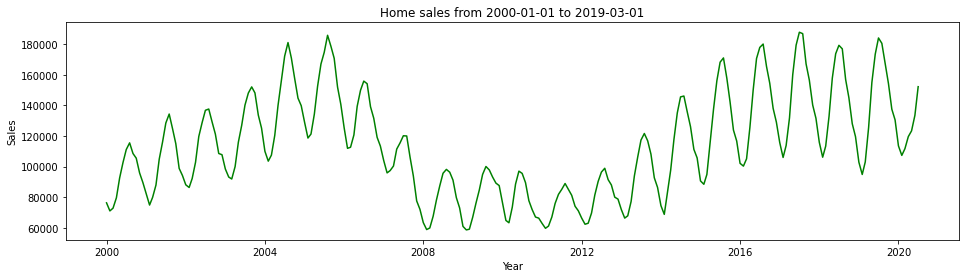

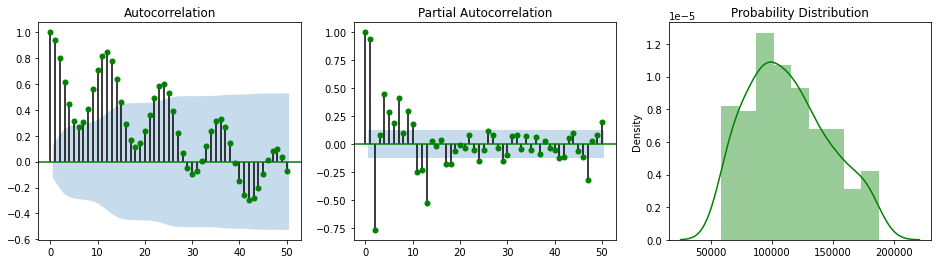

In [ ]:
'''
draw_properties: plots time series data, autocorrelation, partial autocorrelation graphs, and histogram of data points. 
'''

def draw_properties(df_data, plot_name="Time Series plot"):
    
    plt.figure(figsize=(16,4))
    plt.plot(df_data, 'g')
    plt.title(plot_name)
    plt.ylabel('Sales')
    plt.xlabel('Year')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(df_data, ax=axes[0,0], lags=50, color='g');
    plot_pacf(df_data, ax=axes[0,1], lags=50 ,color='g');
    sns.distplot(df_data, ax=axes[0,2], color='g')
    axes[0,2].set_title("Probability Distribution")

draw_properties(df, 'Home sales from 2000-01-01 to 2019-03-01');



Observing the time series plot, we see an increasing trend from 2000 to 2006, a decreasing trend from 2007 to 2012 corresponding to the financial crisis and an increasing trend till 2019. Seasonality is also observed here because the housing market is not very active at the beginning of a year. But the sales usually go high in mid-year and by the end of the year sales slow down. From this seasonal observation, we can state that Spring and Summer are good seasons for the housing market.

From the Autocorrelation plot( the correlation of time series data with its own lagged values), we see autocorrelation at lags=12 and 24 are significant. Autocorrelation at lag=1, shows the correlation of y_t and y_t-1. At lag=2 corr(y_t, y_t-2). At lag=12 corr(y_t, y_t-12). Here, data points at time t has high correlation with t-12, meaning a data point is correlated with the data at this month last year. 

Blue shaded area at autocorrelation plot depicts significance level. Within the shaded area, the correlation coefficients indicate weak correlation at those lags, marking them as insignificant.

The partial autocorrelation (PACF) shows the partial correlation of a time series with its own lagged values. PACF gives the pure correlation between two lags by removing the correlation contribution of other lags. We use ACF and PACF of stationary time series to choose a correct order for MA(q) and AR(p) values of ARIMA model respectively. For AR, we look at PACF plot and choose lag value(p) which has significant correlation value before correlations get insignificant. For MA, we look at ACF plot and do the same. 



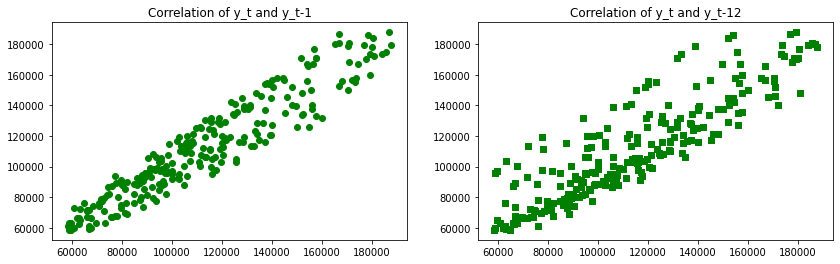

In [ ]:
def plot_correlation(df_data):
  fig, axes = plt.subplots(1,2, squeeze=False)
  fig.set_size_inches(14,4)
  axes[0,0].scatter(x=df_data[1:], y=df_data.shift(1)[1:], color='g')
  axes[0,1].scatter(x=df_data[12:], y=df_data.shift(12)[12:], color='g', marker="s")
  axes[0,0].set_title('Correlation of y_t and y_t-1')
  axes[0,1].set_title('Correlation of y_t and y_t-12')
plot_correlation(df)

There is a high correlation from the scatterplots. 


In [ ]:
test_start = '2018-01-01'
training_df = df[:test_start]
test_df = df[test_start:]

For our model, the training data contains home sales data from 2000 to 2018 and test data contains data from 2018 to 2019. Random sampling 
isn't possible because the temporal behavior of time series data is to be kept intact.

##Time series components: Trend, Seasonality, Cycles, Residuals
Time series data, Y is a combination of Trend, Cycles, Seasonality and Residuals. 
Trend - long-term updward or downward movement. 
Cycle - periodic variation due to economic movements and is different from seasonal variation because cycles occur at intervals such as every 6-10 years, whereas seasonal variation occurs in shorter time intervals. 
Seasonality - variation in data due to seasons. Ice cream sales are high in summer, heating oil sales are high in winter but low in summer.
Residuals - a componenet left after other components removed from time series data. It is randomly distributed and follows ~ N(0,1)

Time series data is either additive or multiplicative. 
Y = T + C + S + R (additive)

Y = T * C * S * R(multiplicative)

for correct decomposition of the data and building a right model, we need to know whether Y is multiplicative or additive. From the given time series plot of our data, we see seasonal variation (seasonality) decreases when the trend decreases ( 2008-2013) and increases when the trend increases ( 2014-2019). So, our data is multiplicative, because in multiplicative time series, small values for trend T results in small S,due to multiplication of S by T. 


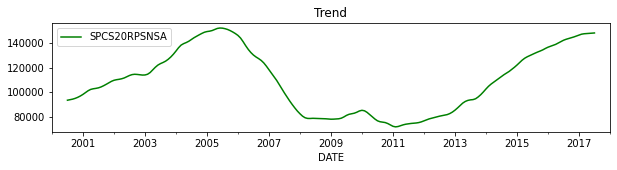

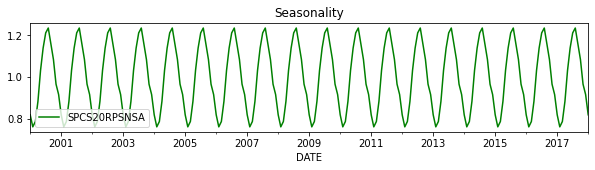

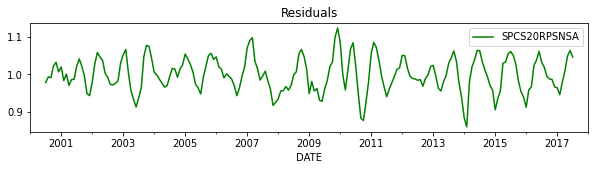

In [ ]:
def time_series_decompose(df, model_type):
    '''
    Plots trend, seasonality and residuals 
    '''
    decomposed_model = seasonal_decompose(df,model=model_type)
    decomposed_model.trend.plot(figsize=(10,2), title='Trend', color='g');
    decomposed_model.seasonal.plot(figsize=(10,2), title='Seasonality', color='g');
    decomposed_model.resid.plot(figsize=(10,2), title='Residuals', color='g');
    return decomposed_model

decomposed_model = time_series_decompose(training_df, 'multiplicative')

Here, the trend is calculated from moving average. We get a seasonal component by dividing time series by trend, S=Y/T. For the graph of seasonality, y=1.2 means there were 20% more sales for some time X. In other words, X has a seasonal effect of +20% or 1.2 *T. Whereas, y=0.8 in time Z means a 20% decrease in sales. Residuals are computed as R = Y/(S*T) 

To examine seasonality, home sales for each year are plotted.
Every year follows a similar pattern with some deviation: house sales are high in summer, low in winter. 

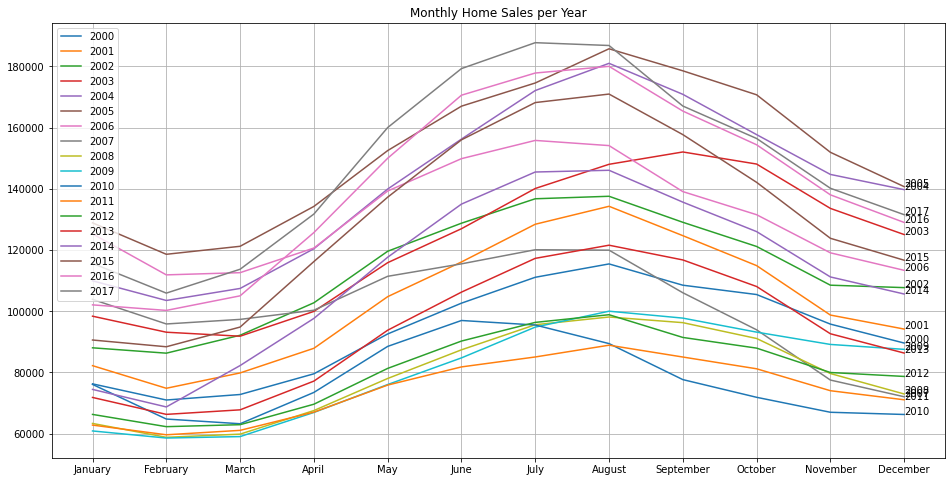

In [ ]:
def house_sale_each_year(df):
  plt.figure(figsize=(16,8))
  plt.grid(which='both')
  years = int(np.round(len(df)/12))
  for i in range(years):
      index = df.index[i*12:(i+1)*12]
      plt.plot(df.index[:12].month_name(),df.loc[index].values);
      plt.text(y=df.loc[index].values[11], x=11, s=df.index.year.unique()[i]);
  plt.legend(df.index.year.unique(), loc=0);
  plt.title('Monthly Home Sales per Year');

house_sale_each_year(training_df)

## Stationarity in time series data:
The presence of trend and/or seasonality in a time series data means it is non-staionary. Stationarity means the statistical properties of data( mean, variance, standard deviation) remain constant over time. We want stationarity to make statistical assumptions about the data for model building and the model is capable of performing under those assumptions only. With non-stationary data, the statistical properties of the data changes and the model doesn't represent the true nature of data any longer thus invalidating our forecasting/prediction. Non-stationary data requires another model to be fit. However, this model may be valid for a short time. After that, we have change the model again. The whole process becomes inefficient and unreliable.

We transform the data to make it staionary before fitting a model. Differencing is one way we can make the data stationary. 

To check for stationarity, we examine the time series plot to identify trend or seasonality. Another option is to use Augmented Dickey Fuller test. ADF test result provides P value. P value >= 0.05 means the data is not stationary, otherwise data is stationary.

The given data is not stationary because it has trend and seasonality components. The ADF test also confirms the data is not stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller
def stationarity_check(data):
    '''
    Adfuller test to test stationarity on given time series data.
    p >= 0.05 means the data is not stationary, otherwise (p < 0.05) it is stationary.
    
    '''
    p=adfuller(data['SPCS20RPSNSA'])[1]
    if p >= 0.05:
        print("Time series data is not stationary. Adfuller test pvalue={}".format(p))
    else:
        print("Time series data is stationary. Adfuller test pvalue={}".format(p))

stationarity_check(df)

Time series data is not stationary. Adfuller test pvalue=0.15122726606240855


## Data transformation: Log transformation and differencing

Home sales index data is multiplicative where Y= T*S*R. Cycles aren't present in this data. (S)ARIMA models are linear models, and we can't fit this to data generated by a multiplicative process Y = T*S*R. So, We have to make Y linear. As a result, we logtransform the data to make it linear.
log(Y) = log(T) + log(S) + log(R).
The data is also smoother after log transformation. Also, we take 1st order of Integration (differencing) to remove trend and take 12th order integration to remove seasonality from the data. Now the time series data is stationary.

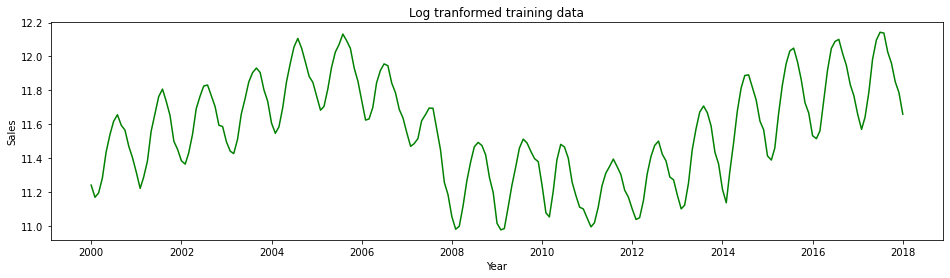

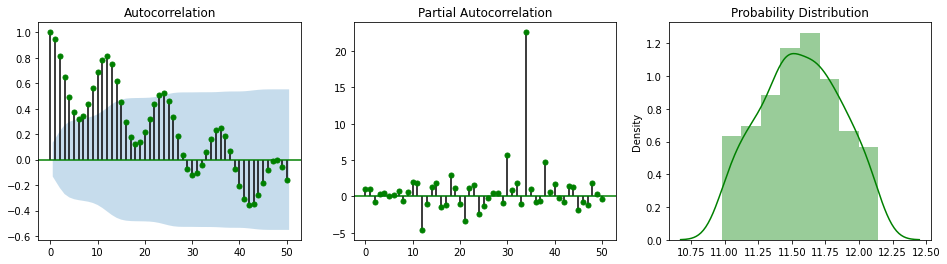

In [ ]:
log_data = np.log(training_df)
draw_properties(log_data, 'Log tranformed training data')

In [ ]:
stationarity_check(log_data)

Time series data is not stationary. Adfuller test pvalue=0.22608313322307916


Differencing means the difference between y at time=t and y at time=t-x.
diff_1 =  y_t - y_t-1
Differencing makes the data stationary by removing time series components.

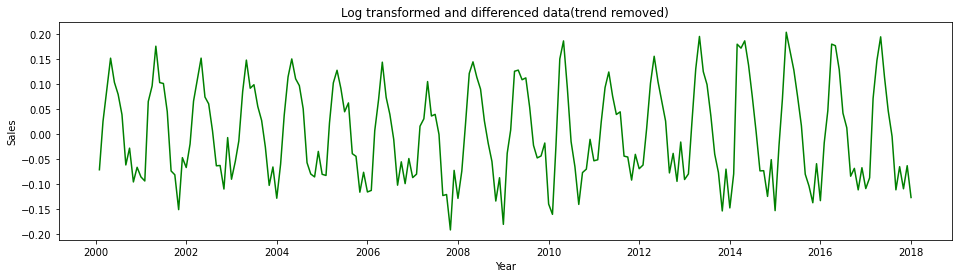

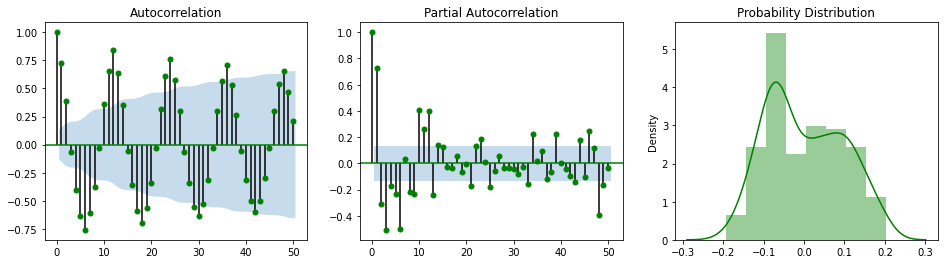

In [ ]:
logged_first_order_data = log_data.diff()[1:]
draw_properties(logged_first_order_data, 'Log transformed and differenced data(trend removed)')

In [ ]:
stationarity_check(logged_first_order_data)

Time series data is not stationary. Adfuller test pvalue=0.2052844476380023


We also take 12th order difference to remove seasonality because monthly data has seasonality at lag=12. The ACF of log transformed data also corroborates this.

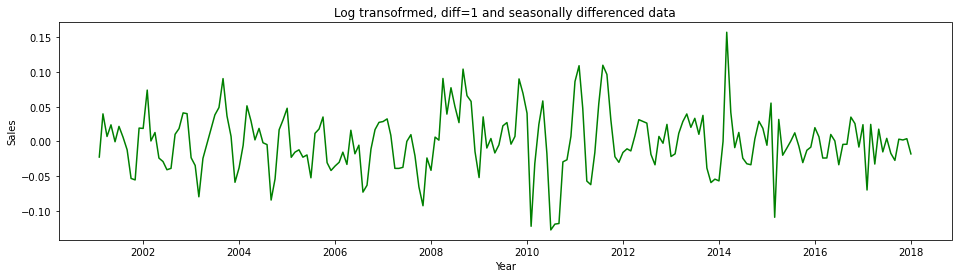

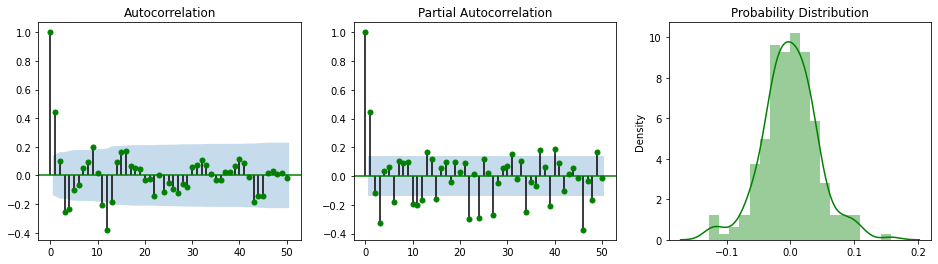

In [ ]:
season_diffed_data = logged_first_order_data.diff(12)[12:]
draw_properties(season_diffed_data, 'Log transofrmed, diff=1 and seasonally differenced data')

Data is stationary and the histogram looks like Normal Distribution, a property of stationary data. By differencing we only get the small variations between time steps, which are normally distributed with constant mean and variance.

In [ ]:
stationarity_check(season_diffed_data)

Time series data is stationary. Adfuller test pvalue=0.0006250945475048601


# Model Fitting
With the transformed stationary data at hand, we fit the model for prediction. SARIMA/ Seasonal ARIMA, part of ARIMA family, can model seasonal componenet of time series data. 
AR or Auto Regressive model regresses on its lagged values, considered independent variables, and the time series itself becomes the dependent variable. y = a_0 + a_1*y_t-1 + a_2*y_t-2, ....., a_k*y_t-k.
We have to choose the number of time steps to use as independent variables. We use PACF to determine how many lags to use. PACF of stationary data has significant autocorrelation at lag=1 and the next autocorrelation at Lag=2 becomes insignificant. Ideally, AR order p should be 1. However, we do parameter search on p (from 0 to 2) to search for the optimal value. 

I or order of integration means the number of times to difference the data to make the data stationary. 

MA or Moving Average model means the time series is y regressed on resdiuals w. y = a_0 + a_1*w1 + a_2*w2 + .... + a_k*wk
We look at ACF plot to find the order (q) of MA part of ARIMA model. We also do grid search on q(from 0 to 2) to find an optimal model. 

Seasonal model - Seasonality is modelled with 4 parameters (P,D,Q,s). 
 P, D and Q are similar to AR, I and MA parameters, but for seasonal componenet of the series. 
Choose P by looking at PACF and Q by looking at ACF. Number of seasonal differences have been taken is D. Frequency of seasonal effect is defined by s.
P = 1 for the significant correlation at lag=12, however But we do a grid search on P = [0-2]

D=1 - we difference for seasonality once

Q=1 due to strong correlation at lag=12 according to ACF plot. Still we do a grid search on Q=[0-2].

s=12 - seasonality frequency, every 12 months

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

class Sarima:
  def __init__(self, train_data, p,q,P,Q,d=1,D=1,s=12):
    self.train_data = train_data
    self.p = p
    self.q=q
    self.P = P
    self.Q = Q
    self.d = d
    self.D=D
    self.s = s
    self.best_aic = np.Inf
    self.best_bic =np.Inf
    self.best_hqic = np.Inf
    self.best_order = (0,0,0)
    self.models = []
    self.model = 0
  
  def is_current_best_model(self):
    no_of_lower_metrics = 0
    if self.model.aic <= self.best_aic: no_of_lower_metrics+=1
    if self.model.bic <= self.best_bic: no_of_lower_metrics+=1
    if self.model.hqic <= self.best_hqic:no_of_lower_metrics+=1
    return no_of_lower_metrics >= 2

  def best_selection(self):
    for p_ in self.p:
        for q_ in self.q:
            for P_ in self.P:
                for Q_ in self.Q:
                        currentOrder = (p_,q_,P_,Q_)
                        print("Current Order (p,q,P,Q): "+ str(currentOrder))
                        
                        self.model = SARIMAX(endog=self.train_data,order=(p_,self.d,q_), seasonal_order=(P_,self.D,Q_,self.s),
                                        enforce_invertibility=False).fit()
                        self.models.append(self.model)

                        
                        if self.is_current_best_model() == True:
                            self.best_aic = np.round(self.model.aic,0)
                            self.best_bic = np.round(self.model.bic,0)
                            self.best_hqic = np.round(self.model.hqic,0)
                            self.best_order = (p_,self.d,q_,P_,self.D,Q_,self.s)
                            current_best_model = self.model
                            self.models.append(self.model)
                            print('========================================================================')
                            print("Best model so far: SARIMA" +  str(self.best_order) + 
                                  " AIC:{} BIC:{} HQIC:{}".format(self.best_aic,self.best_bic,self.best_hqic)+
                                  " resid:{}".format(np.round(np.exp(current_best_model.resid).mean(),3)))
                            print('========================================================================')
                            print()


    print('\n')
    print(current_best_model.summary())                
    return current_best_model, self.models 

x=range(3)
sarima = Sarima(log_data, x,x,x,x)
best_model, models = sarima.best_selection()

Current Order (p,q,P,Q): (0, 0, 0, 0)
Best model so far: SARIMA(0, 1, 0, 0, 1, 0, 12) AIC:-701.0 BIC:-698.0 HQIC:-700.0 resid:352.481

Current Order (p,q,P,Q): (0, 0, 0, 1)
Best model so far: SARIMA(0, 1, 0, 0, 1, 1, 12) AIC:-775.0 BIC:-769.0 HQIC:-773.0 resid:352.48

Current Order (p,q,P,Q): (0, 0, 0, 2)
Current Order (p,q,P,Q): (0, 0, 1, 0)
Current Order (p,q,P,Q): (0, 0, 1, 1)
Current Order (p,q,P,Q): (0, 0, 1, 2)
Current Order (p,q,P,Q): (0, 0, 2, 0)
Current Order (p,q,P,Q): (0, 0, 2, 1)
Current Order (p,q,P,Q): (0, 0, 2, 2)
Current Order (p,q,P,Q): (0, 1, 0, 0)
Current Order (p,q,P,Q): (0, 1, 0, 1)
Best model so far: SARIMA(0, 1, 1, 0, 1, 1, 12) AIC:-810.0 BIC:-800.0 HQIC:-806.0 resid:352.48

Current Order (p,q,P,Q): (0, 1, 0, 2)
Best model so far: SARIMA(0, 1, 1, 0, 1, 2, 12) AIC:-813.0 BIC:-800.0 HQIC:-808.0 resid:352.48

Current Order (p,q,P,Q): (0, 1, 1, 0)
Current Order (p,q,P,Q): (0, 1, 1, 1)
Current Order (p,q,P,Q): (0, 1, 1, 2)
Current Order (p,q,P,Q): (0, 1, 2, 0)
Current

Through grid search of parameters p,q,P,Q, we search for the best model by taking statistical metrics AIC, BIC, HQIC as evaluation criteria. Lower AIC, BIC, HQIC indicate better model rewarding goodness-of-fit (log-likelihood) and penalising overfitting. We choose a model over the other if 2 of the 3 metrics are lower. 

By fitting model to log transformed data and setting d=1 and D=1, the model will do the differencing for us. The best model show we need not have AR features, but only MA and seasonal MA feautres.


To predict home sales from 2018-01-01 to 2019-12-01 we use MAPE - mean absolute percentage error. Our best SARIMA model has order=(0,1,2), and seasonal_order=(0,1,1,12). 

In the predict function:
1. type = 'levels' means predicted values will be at the same level with training values. Since our training data were log transformed, the prediction will be in that form as well. So, we use np.exp() to scale the predicted values to original data because np.exp(np.log(original data)) = original data
2. dynamic = True means using the predicted value for time = t as a predictor for time = t+1.


MAPE:6.17%


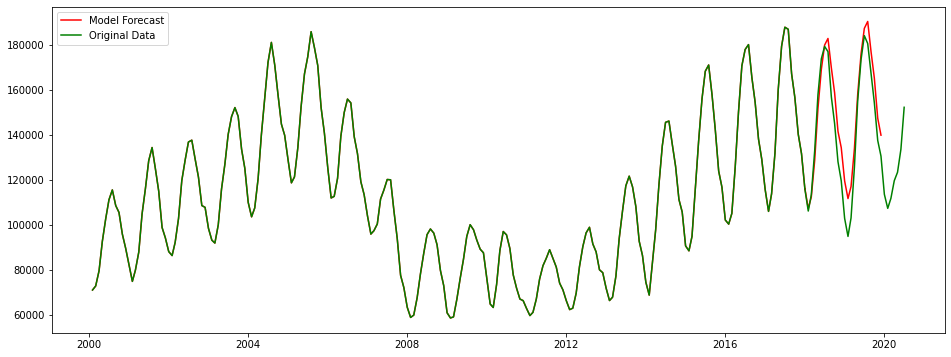

In [23]:
def mean_abs_pct_error(actual, forecast):
    err=0
    n = len(forecast)
    for i in range(n):
        tmp = (actual.values[i] - forecast.values[i])/actual.values[i]
        err += np.abs(tmp)
    
    return err[0] * 100/n

predictions=np.exp(best_model.predict(start=test_start,end='2019-12-01', dynamic=True, typ='levels'))
print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_df,predictions),2)))

def plot_prediction_on_data(train, best_model, preds):
  model_data = train.values[1:].reshape(216) - best_model.resid[1:]
  model_data = pd.concat((model_data,preds))
  plt.figure(figsize=(16,6))
  plt.plot(model_data, color='r')
  plt.plot(df[1:], color = 'g')
  plt.legend(['Model Forecast','Original Data'])
plot_prediction_on_data(training_df, best_model, predictions)

By plotting the predicted values with original data, we find the model  successfully capturing the seasonal effect, but not perfectly predicting the trend. The model struggels to predict the downward trend due to small training data. 

To capture trend quicker we can add AR terms to the model and have less MAPE. The plot below shows the models performing better than best model in terms of test MAPE are in green.

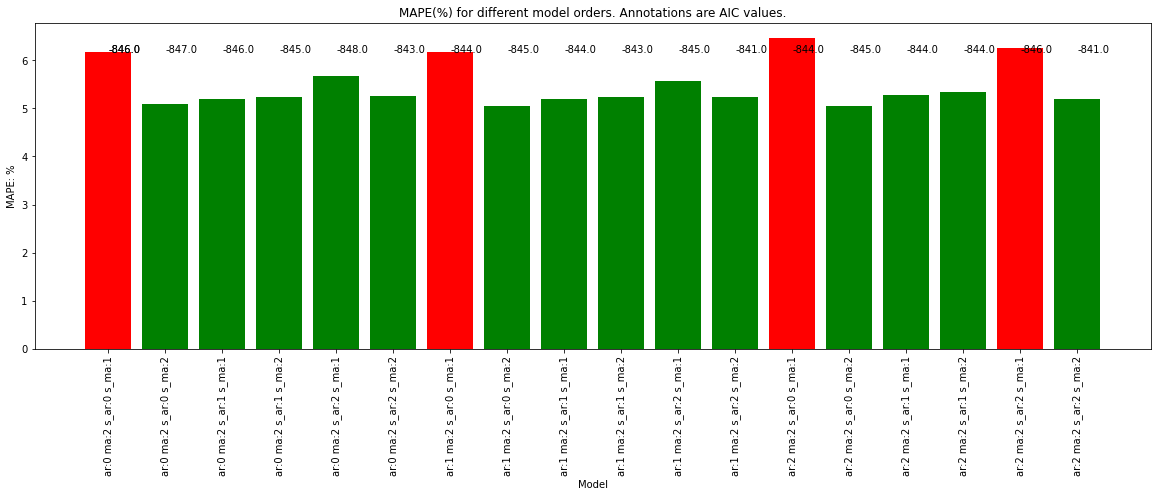

In [26]:
def plot_mape_aic_different_models(model_properties):
  colors = ['g' if x < 6.05 else 'r' for x in model_properties['test_score']]
  plt.figure(figsize=(20,6));
  plt.bar(model_properties['model_order'],model_properties['test_score'], color= colors);
  plt.xlabel('Model');
  plt.ylabel('MAPE: %');
  plt.title('MAPE(%) for different model orders. Annotations are AIC values.')
  for i,aic in enumerate(model_properties['aic']):
      plt.annotate(np.round(aic,0), (model_properties['model_order'][i], model_properties['test_score'][1]));
  plt.xticks(rotation=90)

def different_model_order_plot(models):
  test_scores = []
  model_orders = []
  model_aics = []
  for model in models:
      if model.aic < -840:
          #model_order = (model.model_orders['ar'], model.model_orders['ma'],model.model_orders['seasonal_ar'],model.model_orders['seasonal_ma']/12)
          model_order = "ar:" + str(model.model_orders['ar']) + " ma:" + str(model.model_orders['ma']) + " s_ar:" + str(int(model.model_orders['seasonal_ar']/12)) + " s_ma:" + str(int(model.model_orders['seasonal_ma']/12))
          model_orders.append(model_order)
          model_aics.append(model.aic)
          
          predictions=np.exp(model.predict(start=test_start, end='2019-12-01', dynamic=True, typ='levels'))    

          mape = mean_abs_pct_error(test_df,predictions)
          test_scores.append(np.round(mape,3))
  model_properties = {'aic':models_aic, 'model_order':models_order, 'test_score':tests_score}  

  plot_mape_aic_different_models(model_properties)

different_model_order_plot(models)

We add AR terms to the model to get improvement in test metrics decreasing test MAPE to 5.23%, from 6.17%, the test MAPE of the optimal model.The AIC, BIC and HQIC are higher than the best model meaning we're overfitting. With about 300 data points and 6 features in a linear model had led to overfitting. 

In [33]:
#ar_added_model = SARIMAX(endog=log_transformed_data,order=(1,1,2), seasonal_order=(1,1,2,12),
                                        #enforce_invertibility=False).fit()
#ar_added_model.summary()

def custom_model(data, ar_p=0, ma_q=0, s_ar_p=0, s_ma_q=0):
  ar_added_model = SARIMAX(endog=data,order=(ar_p,1,ma_q), seasonal_order=(s_ar_p,1,s_ma_q,12),
                                        enforce_invertibility=False).fit()
  return ar_added_model

#log_data
cust_model = custom_model(log_data,1,2,1,2)
print(cust_model.summary())

cust_model_pred = np.exp(cust_model.predict(start=test_start,end='2019-12-01', dynamic=True, typ='levels'))
print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_df,cust_model_pred),2)))

                                 Statespace Model Results                                 
Dep. Variable:                       SPCS20RPSNSA   No. Observations:                  217
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                 428.650
Date:                            Sat, 17 Oct 2020   AIC                           -843.300
Time:                                    10:52:59   BIC                           -820.073
Sample:                                01-01-2000   HQIC                          -833.904
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0225      0.139     -0.161      0.872      -0.295       0.250
ma.L1          0.5422      0.113   